In [1]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import imageio
import glob
import cv2
import skimage
from imageio import imread
import csv

In [2]:
data = open("/home/houcem/data/motor_output.p", "rb+")

In [3]:
unpickler = pickle.Unpickler(data)

In [4]:
training = unpickler.load()

In [5]:
data.close()

In [6]:
len(training)

50000

In [7]:
training[7]

[0.41165560483932495, 0.0002735029556788504]

In [8]:
training_images = []
for image_path in sorted(glob.glob("/home/houcem/data/rgb/*.png")):
    image = imageio.imread(image_path)
    #image = cv2.normalize(image,None, 0, 1, cv2.NORM_MINMAX,  dtype=cv2.CV_32F)
    training_images.append(image)

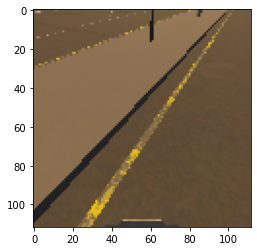

In [9]:
plt.imshow(training_images[7])

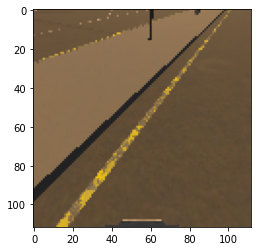

In [10]:
plt.imshow(training_images[8])

# Creating a generator to load and preprocess the images

In [8]:
csv_path = "/home/houcem/data/data.csv"
sample_size = sum(1 for row in open(csv_path))

In [9]:
batch_size = 16

In [20]:
def generator(csv_path, batch_size):
    X1_train = []
    X2_train = []
    y_train = []
    batchcount = 0
    
    while True: #Keeping the generator running
        with open(csv_path) as f:
            next(f)
            for line in f:
                img_x_path, throttle, steering_angle, img_y_path = line.split(',')
                
                #Loading and Normalizing the input frame
                img_x = imread(str(img_x_path))
                img_x = img_x
                
                #Packing the motor input into a numpy array
                motor_input = np.asarray([float(throttle), float(steering_angle)])
                
                #Loading and Normalizing the target frame
                img_y = imread(str(img_y_path).rstrip("\n"))
                img_y = img_y
                
                #Packing and adding the inputs and targets into the batch
                X1_train.append(motor_input)
                X2_train.append(img_x)
                y_train.append(img_y)
                   
                batchcount += 1    
                    
                if batchcount == batch_size:
                    X1_train = np.asarray(X1_train)
                    X2_train = np.asarray(X2_train)
                    y_train = np.asarray(y_train)
                    yield([X1_train, X2_train], y_train)
                    X1_train = []
                    X2_train = []
                    y_train = []
                    batchcount = 0

# Defining the model

In [11]:
from tensorflow import keras

In [12]:
from keras.layers import Conv2D, Conv2DTranspose, Dense, Input, Flatten, Concatenate, Reshape, BatchNormalization, Dropout, MaxPooling2D
from keras.activations import relu, linear
from keras import Model

In [22]:
#Defining the motor input
y = Input(shape=(2,))


#Defining the ResNet Encoder input
image_input = Input(shape=(112,112,3,))
x = Conv2D(128, (3,3), activation = 'relu', padding = 'same')(image_input)
x = MaxPooling2D()(x)
x = Conv2D(64, (3,3), activation = 'relu', padding = 'same')(x)
x = MaxPooling2D()(x)
x = Conv2D(32, (3,3), activation = 'relu', padding = 'same')(x)
x = MaxPooling2D()(x)
x = Conv2D(16, (3,3), activation = 'relu', padding = 'same')(x)
x = MaxPooling2D()(x)
x = Conv2D(4, (3,3), activation = 'relu', padding = 'same')(x)
x = Flatten()(x)

#Concatenating both vectors
concat = Concatenate()([x, y])

z = Dense(784, activation ='relu')(concat)

encoder = Model(inputs= [y, image_input], outputs = z)

encoder.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 112, 112, 3) 0                                            
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 112, 112, 128 3584        input_7[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_4 (MaxPooling2D)  (None, 56, 56, 128)  0           conv2d_6[0][0]                   
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 56, 56, 64)   73792       max_pooling2d_4[0][0]            
____________________________________________________________________________________________

In [23]:
input_decoder = Input(shape=(784,))

d = Reshape((28,28,1))(input_decoder)
d = Conv2DTranspose(128,(2, 2), strides=1, activation='relu', padding='same')(d)
d = Conv2DTranspose(128,(2, 2), strides=1, activation='relu', padding='same')(d)
d = Conv2DTranspose(128,(2, 2), strides=1, activation='relu', padding='same')(d)
d = Conv2DTranspose(128,(2, 2), strides=2, activation='relu', padding='same')(d)
d = Conv2DTranspose(64,(2, 2), strides=1, activation='relu', padding='same')(d)
d = Conv2DTranspose(64,(2, 2), strides=1, activation='relu', padding='same')(d)
d = Conv2DTranspose(64,(2, 2), strides=1, activation='relu', padding='same')(d)
d = Conv2DTranspose(64,(2, 2), strides=2, activation='relu', padding='same')(d)
decoded = Conv2D(3, (3, 3), strides = 1, activation='relu', padding='same')(d)

Decoder = Model(inputs = input_decoder, outputs = decoded)

In [24]:
Decoder.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_transpose_8 (Conv2DTr (None, 28, 28, 128)       640       
_________________________________________________________________
conv2d_transpose_9 (Conv2DTr (None, 28, 28, 128)       65664     
_________________________________________________________________
conv2d_transpose_10 (Conv2DT (None, 28, 28, 128)       65664     
_________________________________________________________________
conv2d_transpose_11 (Conv2DT (None, 56, 56, 128)       65664     
_________________________________________________________________
conv2d_transpose_12 (Conv2DT (None, 56, 56, 64)        3283

In [26]:
img_input = Input(shape=(112, 112, 3,))
motor_input = Input(shape=(2,))
Encoded = encoder([motor_input,img_input])
Decoded = Decoder(Encoded)

autoencoder = Model(inputs = [motor_input,img_input], outputs = Decoded)

# Preprocessing Data and Splitting the x and y

In [17]:
img_training_x=np.asarray(training_images[0:49999])
motor_training=np.asarray(training[0:49999])
img_training_y=np.asarray(training_images[1:50000])

In [18]:
del(training_images)

In [27]:
autoencoder.compile(loss = 'mse', optimizer= keras.optimizers.Adam())

In [21]:
autoencoder.fit(x=[motor_training,img_training_x], y=img_training_y, batch_size=4,epochs=5)

Epoch 1/5
12500/12500 [==============================] - 258s 21ms/step - loss: 375.9888
Epoch 2/5
12500/12500 [==============================] - 258s 21ms/step - loss: 252.4972
Epoch 3/5
12500/12500 [==============================] - 258s 21ms/step - loss: 231.8503
Epoch 4/5
12500/12500 [==============================] - 259s 21ms/step - loss: 222.7617
Epoch 5/5
12500/12500 [==============================] - 259s 21ms/step - loss: 217.1815


# Using fit generator to fit the data

In [ ]:
autoencoder.fit(generator(csv_path, batch_size), steps_per_epoch = sample_size/batch_size, epochs = 5)

Epoch 1/5
2080/3125 [==================>...........] - ETA: 1:05 - loss: 1115.1836

# Testing and visualizing the output

In [18]:
autoencoder.load_weights("autoencoder_5.h5")

In [19]:
img_test_x=np.asarray(training_images[0:1000])
motor_test=np.asarray(training[0:1000])
img_test_y=np.asarray(training_images[1:1001])

In [20]:
result_images = autoencoder.predict([motor_test, img_test_x])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


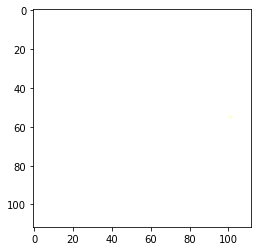

In [21]:
plt.imshow(result_images[800])

In [22]:
goal_img = cv2.normalize(result_images[0] ,None , 0, 1, cv2.NORM_MINMAX)

In [23]:
goal_img

array([[[0.01959432, 0.01643866, 0.01085307],
        [0.01113187, 0.01073424, 0.00712851],
        [0.00975791, 0.00998464, 0.0068828 ],
        ...,
        [0.00999466, 0.00986404, 0.00681999],
        [0.01010691, 0.00996173, 0.00693289],
        [0.01025494, 0.00995201, 0.00695414]],

       [[0.01857688, 0.0149733 , 0.00723211],
        [0.01323458, 0.01297303, 0.00536994],
        [0.0146868 , 0.01508244, 0.01006305],
        ...,
        [0.01141569, 0.01117359, 0.00787739],
        [0.0106555 , 0.0105527 , 0.00742914],
        [0.01025494, 0.00995201, 0.00695414]],

       [[0.0119915 , 0.01716799, 0.01047381],
        [0.01168451, 0.01416348, 0.00602158],
        [0.01241948, 0.01253156, 0.0084496 ],
        ...,
        [0.01025494, 0.00995201, 0.00695414],
        [0.01025494, 0.00995201, 0.00695414],
        [0.01025494, 0.00995201, 0.00695414]],

       ...,

       [[0.7208882 , 0.5734059 , 0.39941034],
        [0.7238808 , 0.5741253 , 0.3971303 ],
        [0.7227456 , 0

In [22]:
img_test_y[0]

array([[[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       ...,

       [[100,  81,  53],
        [ 99,  80,  52],
        [100,  81,  54],
        ...,
        [100,  79,  55],
        [102,  80,  55],
        [ 99,  79,  56]],

       [[ 99,  81,  54],
        [101,  82,  56],
        [103,  83,  58],
        ...,
        [ 98,  78,  55],
        [101,  79,  55],
        [102,  80,  55]],

       [[102,  83,  57],
        [105,  84,  60],
        [106,  86,  61],
        ...,
        [ 98,  77,  54],
        [100,  78,  54],
        [102,  79,  55]]

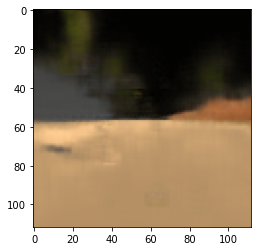

In [24]:
plt.imshow(goal_img)